In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

In [14]:
train_dir = "/kaggle/input/coffee-bean-tanvir/train"
test_dir = "/kaggle/input/coffee-bean-tanvir/test"

# Training Data Generator (with validation split)
# ======================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   # 20% of training data for validation
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'    # <-- this is the training subset
)

# Validation generator
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # <-- this is the validation subset
)

# ======================
# Test Data Generator (final evaluation)
# ======================
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Quick sanity check
# ======================
print("Train classes mapping:", train_gen.class_indices)
print("Validation classes mapping:", val_gen.class_indices)
print("Test classes mapping:", test_gen.class_indices)

Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Train classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Validation classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Test classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}


In [15]:
# Self-Attention Block (lightweight)
# ======================
def self_attention_block(x, num_heads=4, key_dim=32, ff_dim=128):
    """
    Transformer-style Self-Attention Block:
    MHSA + FFN (with residuals and LayerNorm)
    """
    h, w, c = x.shape[1], x.shape[2], x.shape[3]
    reshaped = layers.Reshape((-1, c))(x)   # (batch, H*W, C)

    # Multi-Head Self-Attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(reshaped, reshaped)
    attn_output = layers.Add()([reshaped, attn_output])
    attn_output = layers.LayerNormalization()(attn_output)

    # Feed Forward Network (2-layer MLP)
    ffn = layers.Dense(ff_dim, activation='relu')(attn_output)
    ffn = layers.Dense(c)(ffn)   # project back to channel dim
    ffn_output = layers.Add()([attn_output, ffn])
    ffn_output = layers.LayerNormalization()(ffn_output)

    # Reshape back
    out = layers.Reshape((h, w, c))(ffn_output)
    return out


In [16]:
# Build Self-Attention CNN
# ======================
def build_sa_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Conv Block 1 (no attention yet)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    # Conv Block 2 (add attention+FFN at 32×32)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = self_attention_block(x, num_heads=4, key_dim=32, ff_dim=128)

    # Conv Block 3 (add attention+FFN at 16×16)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = self_attention_block(x, num_heads=4, key_dim=32, ff_dim=256)

    # Global Average Pooling
    gap = layers.GlobalAveragePooling2D()(x)

    # Dense Head
    dense = layers.Dense(256, activation='relu')(gap)
    dense = layers.Dropout(0.5)(dense)
    outputs = layers.Dense(num_classes, activation='softmax')(dense)

    model = models.Model(inputs, outputs)
    return model

In [17]:
# Compile & Train
# ======================
num_classes = train_gen.num_classes
sa_model = build_sa_cnn(input_shape=(128,128,3), num_classes=num_classes)

sa_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = sa_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 348ms/step - accuracy: 0.2724 - loss: 1.6387 - val_accuracy: 0.3833 - val_loss: 1.3629
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.3892 - loss: 1.2368 - val_accuracy: 0.5958 - val_loss: 0.9299
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.5870 - loss: 0.8434 - val_accuracy: 0.6458 - val_loss: 0.7341
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step - accuracy: 0.6030 - loss: 0.7510 - val_accuracy: 0.7125 - val_loss: 0.6218
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.7276 - loss: 0.6013 - val_accuracy: 0.8792 - val_loss: 0.3260
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.9000 - loss: 0.3103 - val_accuracy: 0.6750 - val_loss: 0.7026
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.8757 - loss: 0.3224 - val_accuracy: 0.9667 - val_loss: 0.1034
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 270ms/step - accuracy: 0.9248 - loss: 0.2275 - val_accuracy: 0

In [18]:
# Feature Extraction (GlobalAveragePooling2D output)
# ======================
feature_extractor = models.Model(
    inputs=sa_model.input,
    outputs=sa_model.layers[-4].output   # GAP output before Dense
)

def extract_features(model, generator):
    features = []
    labels = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        feat = model.predict(x_batch, verbose=0)
        features.append(feat)
        labels.append(np.argmax(y_batch, axis=1))
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

X_train, y_train = extract_features(feature_extractor, train_gen)
X_val, y_val     = extract_features(feature_extractor, val_gen)
X_test, y_test   = extract_features(feature_extractor, test_gen)

In [19]:
# Random Forest Classifier
# ======================
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [20]:
# Validation set evaluation
y_val_pred = rf.predict(X_val)
print("Validation Accuracy (RF):", accuracy_score(y_val, y_val_pred))

# Test set evaluation
y_test_pred = rf.predict(X_test)
print("Test Accuracy (RF):", accuracy_score(y_test, y_test_pred))

# Detailed classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred, target_names=list(train_gen.class_indices.keys())))


Validation Accuracy (RF): 0.9958333333333333
Test Accuracy (RF): 0.985
              precision    recall  f1-score   support

        Dark       0.97      0.98      0.98       100
       Green       1.00      1.00      1.00       100
       Light       1.00      0.99      0.99       100
      Medium       0.97      0.97      0.97       100

    accuracy                           0.98       400
   macro avg       0.99      0.98      0.99       400
weighted avg       0.99      0.98      0.99       400



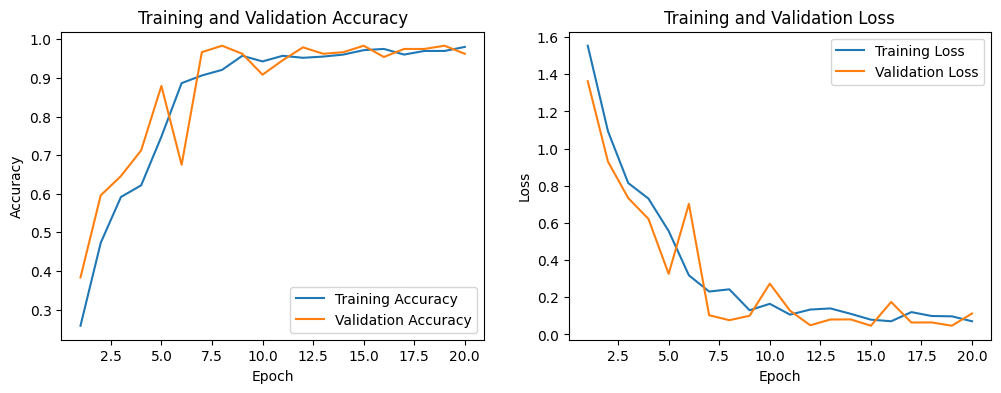

In [21]:
# Training Curves (Accuracy & Loss)
# ======================
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)

plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

Accuracy: 0.985
Precision (macro): 0.9850742574257425
Recall (macro): 0.9849999999999999
F1-score (macro): 0.9850248131203281
Confusion Matrix:
 [[ 98   0   0   2]
 [  0 100   0   0]
 [  0   0  99   1]
 [  3   0   0  97]]

Classification Report:
               precision    recall  f1-score   support

        Dark       0.97      0.98      0.98       100
       Green       1.00      1.00      1.00       100
       Light       1.00      0.99      0.99       100
      Medium       0.97      0.97      0.97       100

    accuracy                           0.98       400
   macro avg       0.99      0.98      0.99       400
weighted avg       0.99      0.98      0.99       400



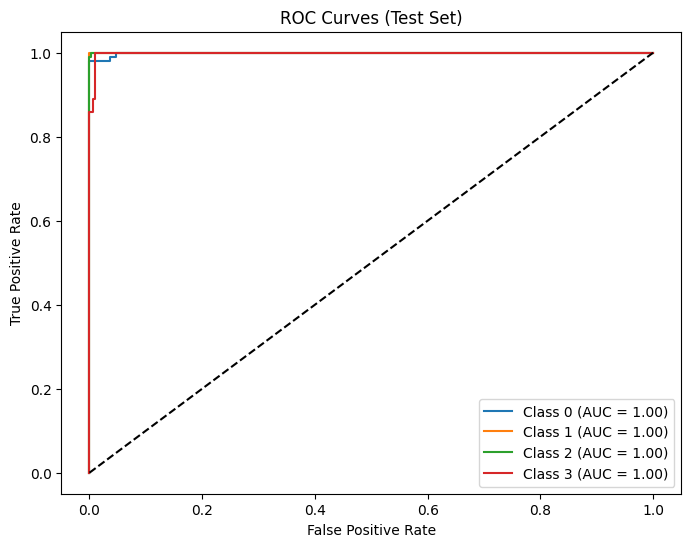

Overall Test AUC: 0.9994583333333332


In [22]:
# ---- Predictions ----
y_test_pred = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)

# ---- Basic Metrics ----
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision (macro):", precision_score(y_test, y_test_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_test_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_test_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=list(train_gen.class_indices.keys())))

# ---- ROC-AUC Curves ----
classes_present = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes_present)

if y_test_bin.shape[1] > 1:  # only if >1 class
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {classes_present[i]} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend()
    plt.show()

    print("Overall Test AUC:", roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'))
else:
    print("ROC-AUC skipped: less than 2 classes present in test set")